In [1]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter as sf

In [2]:
import RouteMap as rm
import Helper_Methods as hm

In [3]:
import Helper_Methods as hm
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter as sf
from shapely.geometry import Point, LineString

class RouteMap:
    def __init__(self,
                 geometry,
                 elevation,
                 limits = None,
                 stops = None,
                 signals = None,
                 threshold = .015,
                 debug = False):
        # Set the global debug parameter
        self._debug = debug
        if(debug): 
            print('DEBUGGER ACTIVE')
        # Set the global distance threshold, default is .015 km.
        self._dist_threshold = threshold
        
        # Generate the empty route dataframe
        self._route_df = pd.DataFrame()
        
        # Assign the geometry input to the route dataframe
        self._route_df['geometry'] = geometry
        
        # Assign the elevation to the route dataframe
        self._route_df['elevation[km]'] = elevation * 0.3048 / 1000  # Converts to km from feet
        
        # Get the latitude and longitude from the geometry of the route dataframe
        self._route_df[['latitude', 'longitude']] = self.geo_to_la_lon(self._route_df['geometry'])
        
        # Generate joint geometry for generating point distances
        self._joint_geometry = self.get_joint_geometry()
        
        # Calculate the distance between points and cumulative distance
        self._route_df['point_distances[km]'] = self.calc_point_distances()
        self._route_df['cumulative_distance[km]'] = self.calc_cum_distances()
        
        # if there is speed limit data,
        if (str(type(stops)) != "<class 'NoneType'>"):
            
            # Rename column for ease of use
            limits=limits.rename(columns = {list(limits.columns)[1]:'SPEEDLIMIT'})
            
            # assign the route points with their speed limits
            self._route_df['speed_limit[km/s]'] = self.apply_speed_limits(limits)
            
        else:
            # Set the default value to 'None'.
            self._route_df['speed_limit[km/s]'] = None

        if(debug): print('speeds assigned')

        # If there is stop data, 
        if (str(type(stops)) != "<class 'NoneType'>"):
            
            # Assign bus stop data using assign_stops
            self._route_df['is_stop'] = self.assign_stops(stops, 0)
        
        # Otherwise:
        else:
            
            # Set the default value to 'None'.
            self._route_df['is_stop'] = False
            
        # If debugging, notify of assigned stops.
        if(debug): print('stops assigned')
        
        # If there is signal data,
        if (str(type(signals)) != "<class 'NoneType'>"):
            
            # Assign the route points with respective stops using assign_stops
            self._route_df['is_signal'] = self.assign_stops(signals, 1, threshold=threshold)
            
        # Otherwise:
        else:
            
            # Assign default signal value of None.
            self._route_df['is_signal'] = False
            
        # If debugging, notify of assigned stops.
        if(debug): print('signals assigned')
            
        
    def calc_point_distances(self):
        """
        calc_point_distances calculates the distances between the route points,
        and returns a pandas series of distances between points in the route.
        
        Parameters:
        None.
        
        Returns:
        a series of distances with indexes corresponding to the route data,
        in units of kilometers.
        """
        
        # Get a copy of the joint_geometry.
        joint_geometry = self._joint_geometry.copy()

        # Calculate the distance between each point using the haversine formula.
        dist_traveled = joint_geometry.apply(lambda x: hm.haversine_formula(x['lat1'],
                                                                            x['lon1'],
                                                                            x['lat2'],
                                                                            x['lon2']),
                                             axis=1)
        
        # Return the distance series.
        return dist_traveled.shift(1)
    
    
    def calc_cum_distances(self):
        """
        calc_cum_distances generates a pandas series tallying the
        cumulative distance travelled between points on the route.
        
        Parameters:
        None.
        
        Returns:
        a pandas series cumulatively summing the kilometers traveled
        by the bus.
        """
        
        # Get the route's point distances.
        point_distances = self._route_df['point_distances[km]']
        
        # tally the cumulative sum and return it.
        return point_distances.cumsum()
    
    
    def apply_speed_limits(self, limits):
        '''
        apply_speed_limits takes in a dataset of city streets and speed limits
        and assigns speed limits to each route point, including the threshold distance.
        
        Parameters:
        limits: geodataframe containing columns where street geometry
                (linestrings) is index 0, and speed limits is index 1
        
        Returns:
        A series of speed limits in km/s corresponding to each point on the route
        '''
        
        # Generate a copy of the speed limits and the route_dataframe geometry
        streets = limits.copy()
        pts = self._route_df.copy()
        
        # Set an overall speed limit of zero
        pts['limit'] = 0
        
        # Set a varaible to hold the last found street index
        last_street_idx = 0
        
        street_segments = []
        # Loop through each point on the route
        for i in range(len(pts)):
            
            # If debugging, update on progress
            if (self._debug): print('{}     points remain'.format(len(pts[pts['limit']==0])), end = "\r")
            
            # Get the current point on the route
            route_pt = pts['geometry'][i]
            
            # If this point was on the street that was last checked, and has no speed limit
            if (route_pt.dwithin(streets['geometry'][last_street_idx], .0001)):
                pts.at[i, 'limit'] = streets['SPEEDLIMIT'][last_street_idx]
                
            # Otherwise, find the next street that a point is located on,
            # Get it's index, and then assign the speed limit to the point.
            else:
                last_street_col = streets.apply(lambda x: x['geometry'].dwithin(route_pt,
                                                                                .0001),
                                                axis=1)
                
                # get all points that the street is on
                true_street_col = (last_street_col[last_street_col == True])
                
                # if there are no streets that intersect the point
                if (len(true_street_col) == 0):
                    
                    # Set the index to the last known index
                    last_street_idx = last_street_idx
                else:
                    # Otherwise, get the intersect index and the corresponding limit
                    last_street_idx = true_street_col.idxmin()
                pts.at[i, 'limit'] = streets['SPEEDLIMIT'][last_street_idx]
                
                # Append the index to street segments
                street_segments.append(last_street_idx)
        self._route_segments_idx = street_segments
        # Return the values as a series in km/s
        return pts['limit'] * 0.00044704 # convert mph to km/s

    
    def assign_stops(self, stops, stop_type, threshold=.015):
        '''
        method assign_stops takes in the existing route map,
        as well as stop geometry and types of stops, and then
        assigns points on the route that stop classification.
        
        Parameters:
        stops: a pandas series of stop points as geometry
        stop_type: a parameter where 0 means a bus stop,
                   and 1 means a signal light.
        threshold: the threshold distance for assigning signal lights, default is 15 meters
                   
        Returns:
        a pandas series indicating stops using the same index as route points.
        '''
        
        # Get a copy of the joint geometry.
        joint_geometry = self._joint_geometry.copy()
        
        # Get the latitude and longitude of the stop data
        stop_lat_lons = self.geo_to_la_lon(stops)
        # set the default stop distance to 999,999,999 kilometers
        joint_geometry['stop_dist'] = 999999999
        
        # Set the default state for being a stop to be False
        joint_geometry['is_stop'] = False
        
        # Loop through each stop in the data
        for i in range(len(stop_lat_lons)):
            
            # If debugging, print progress
            if self._debug: print('{0:.2f}%     '.format(i/len(joint_geometry)*100), end = "\r")
            
            # get the latitude and longitude of the current stop
            la1 = stop_lat_lons['latitude'][i]
            lo1 = stop_lat_lons['longitude'][i]
            
            # using the joint geometry, apply the haversine formula between each point in the route
            # and the current stop.
            joint_geometry['stop_dist'] = joint_geometry.apply(lambda x: hm.haversine_formula(x['lat1'],
                                                                                              x['lon1'],
                                                                                              la1,
                                                                                              lo1),
                                                               axis=1)
            
            # Get the index of the lowest distance route point to the stop
            cord_id = joint_geometry['stop_dist'].idxmin()
            min_val = joint_geometry['stop_dist'].min()

            # if the stop type is a bus stop,
            if(stop_type == 0):
                
                # assign the stop as a bus stop.
                joint_geometry.at[cord_id, 'is_stop'] = True
                
            # If the stop type is a stop signal, and the signal is closer to the stop than the threshold,
            elif(stop_type == 1 and min_val < threshold):
                
                # categorize the point index as a signal stop.
                joint_geometry.at[cord_id, 'is_stop'] = True
            else:
                # Otherwise, dont categorize it as a stop
                joint_geometry.at[cord_id, 'is_stop'] = False
                
        # Return a pandas series of booleans for a stop with indexes corresponding to the route idxs.
        return joint_geometry['is_stop']
    
    
    def smooth_elevation(self, lg:int = 43, deg:int = 3):
        """
        smooth_elevation applies a savgol filter to the
        elevation data in order to de-noise it.

        Parameters:
        lg: length of the filter in number of points per sample,
            default is 43, as an int.
        deg: degree int for filter polynomial, default is 3.

        Returns:
        a series containing the smoothed elevation values.
        """
        # get the points that will be smoothed
        elev_points = self._route_df[('elevation[km]')].values

        # Apply the savgol filter to the points
        y_new = sf(elev_points,
                   lg,
                   deg,
                   axis = 0)

        # replace the elevation values with the
        # smoothed elevation values.
        tmp = pd.DataFrame()
        tmp['elevation[km]'] = y_new
        
        # return the series
        return tmp['elevation[km]'] 
        
        
    def get_joint_geometry(self):
        '''
        get_joint_geometry generates a dataframe of latitude and longitude of
        each index and then the lat and longitude of the next index,
        so to be able to compare the two more easily.
        
        Parameters:
        None
        
        Returns: 
        joint_geometry: a dataframe containing the lat and lon of each point
                        and its subsequent neighbor in the route.
        '''
        lat1 = self._route_df['latitude']
        lon1 = self._route_df['longitude']
        lat2 = self._route_df['latitude'].shift(-1)
        lon2 = self._route_df['longitude'].shift(-1)
        joint_geometry = pd.DataFrame()
        joint_geometry['lat1'] = lat1
        joint_geometry['lon1'] = lon1
        joint_geometry['lat2'] = lat2
        joint_geometry['lon2'] = lon2
        joint_geometry.dropna(inplace=True)
        return joint_geometry
        
        
    def get_gdf(self):
        return gpd.GeoDataFrame(self._route_df)
    
    
    def remove_stops(self):
        self._route_df['is_stop'] = False
        return None
    
    
    def remove_signals(self):
        self._route_df['is_signal'] = False
        return None

    def get_segments_by_id(self):
        return self._route_segments_idx
    
    def get_stops(self):
        return self._route_df[self._route_df['is_stop'] == True].copy()
    
    
    def get_signals(self):
        return self._route_df[self._route_df['is_signal'] == True].copy()
    
    
    def get_elevation(self):
        return self._route_df['elevation[km]'].copy()
    
    
    def set_elevation(self, elev):
        self._route_df['elevation[km]'] = elev
        return self
    
    
    def set_point_distances(self, dist):
        self._route_df['point_distances[km]'] = dist
        self._route_df['cumulative_distance[km]'] = self._route_df['point_distances[km]'].cumsum()
        return self
    
    
    def get_distances(self):
        return self._route_df[['point_distances[km]', 'cumulative_distance[km]']].copy()
    
    
    def erica_distances(self):
        '''
        erica_distances uses the index of the dataframe as a metric of distance
        traveled in units of 1 foot per data point - user beware.
        This returns a value in kilometers.
        '''
        indexes = self._route_df.copy().reset_index(drop=True)
        self._route_df['erica_distances'] =indexes.index*6*6*0.3048/1000
        return self._route_df['erica_distances']
    
    
    def get_grade(self):
        elevation = self.get_elevation().diff()
        distance = self.get_distances()['point_distances[km]']
        grade = elevation / distance
        grade = grade.clip(upper=.10, lower=-.10)
        return grade
    
    def erica_grade(self):
        grade_SG = [0]
        elev = self.get_elevation().copy()
        y_new = list(elev*1000)

        for i in range(1,len(y_new)):
            grade_SG.append((y_new[i]-y_new[i-1])/10.97)

        self._route_df['erica_grade[%]'] = pd.Series(grade_SG)
        
        return self._route_df['erica_grade[%]']
        

    def geo_to_la_lon(self, geometry):
        tmp_df = pd.DataFrame((geometry.apply(hm.get_lat_lon)).tolist())
        tmp_df.columns = ['latitude','longitude']
        return tmp_df[['latitude', 'longitude']]

    
    def get_frict_accel(self):
        '''
        returns a series of accelerations
        '''
        # Get acceleration due to route friction
        # FOR TRUE VALUE, NEEDS BUS FRICITON COEFF
        grade = self.get_grade().copy()
        grad_angle = np.arctan(grade)
        grav_acc = 9.81 # m/s^2
        accel_vect = grav_accel * np.sin(grad_angle)
        return -accel_vect
    
    
    def get_hill_accel(self):
        '''
        returns a series of accelerations
        '''
        # Get acceleration due to hills
        grade = self.get_grade().copy()
        grad_angle = np.arctan(grade)
        grav_acc = 9.81 # m/s^2
        accel_vect = grav_accel * np.cos(grad_angle)
        return accel_vect
    
    
    def plot(self):
        fig, ax = plt.subplots(1, figsize = (8, 4.333))
        self._route_df['grade[%]'] = self.get_grade()
        self._route_df.plot(x='cumulative_distance[km]',
                            y='elevation[km]',
                            ax=ax,
                            c='Green')
        self.get_stops().plot.scatter(x='cumulative_distance[km]',
                                    y='elevation[km]',
                                    ax=ax,
                                    c='lime',
                                    s=20)
        self.get_signals().plot.scatter(x='cumulative_distance[km]',
                                      y='elevation[km]',
                                      ax=ax,
                                      c='orange',
                                      s=20)
        ax1=ax.twinx()
        self._route_df.plot(x='cumulative_distance[km]',
                            y='grade[%]',
                            ax=ax1,
                            c='grey',
                            alpha=0.5)

        ax.set_ylim(0,.2)
        ax1.set_ylabel('Grade [%]')
        return ax


In [4]:
# SKIPPING EVERY 6 POINTS TO MATCH ERICA
rt_ = gpd.read_file("./Data/Routes/rt22_pts.shp")[::6]
#lidar was highest res data for elevation

rt_ = rt_.reset_index(drop=True)
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")
seattle = seattle[(seattle['WATER'] != 1)]
stops = gpd.read_file('./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp')
signals_1 = gpd.read_file('./Data/Signals/Traffic_Signals.shp')
streets = gpd.read_file("./Data/Seattle_Streets/Seattle_Streets.shp")


In [5]:
route_geometry = rt_['geometry']
route_elevation = rt_['Z']
all_stops = stops
all_signals = signals_1['geometry'].reset_index(drop=True)
route_stops = hm.get_stops(all_stops, "22")['geometry'].reset_index(drop=True)
limits = streets[['geometry', 'SPEEDLIMIT']]

In [6]:
route_test_map = RouteMap(route_geometry, route_elevation, limits, route_stops, all_signals, debug = True)

DEBUGGER ACTIVE
speeds assignedmainnnn
stops assigned
signals assigned


In [7]:
route_test_map = rm.RouteMap(route_geometry, route_elevation, limits, route_stops, all_signals, debug = True)

DEBUGGER ACTIVE
speeds assignedmainnnn
stops assigned
signals assigned


Text(0.5, 1.0, 'Distance vs. Elevation and Grade')

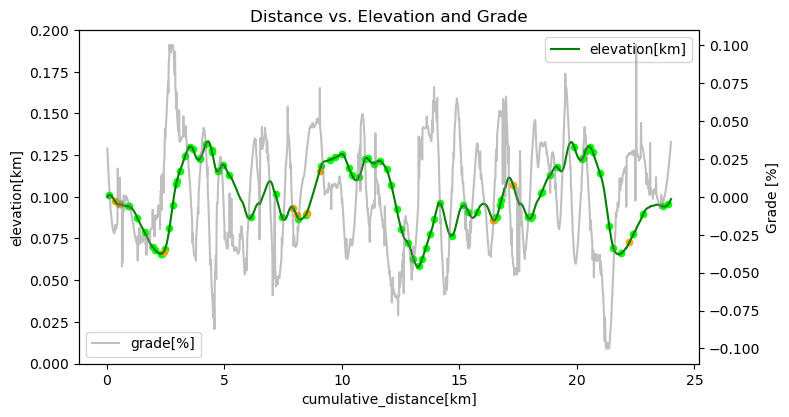

In [8]:
sm_elev = route_test_map.smooth_elevation()
route_sm_map = route_test_map.set_elevation(sm_elev)
route_sm_map.plot()
plt.title('Distance vs. Elevation and Grade')

Text(0.5, 1.0, 'Distance vs. Elevation and Grade (Erica Method)')

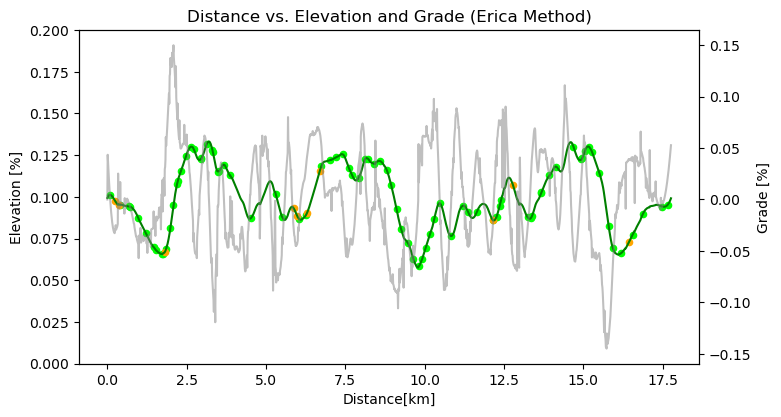

In [9]:
grade = route_test_map.erica_grade()
dist = route_test_map.erica_distances()
elev = route_test_map.get_elevation()
stops = route_test_map.get_stops()
signals = route_test_map.get_signals()
fig, ax = plt.subplots(1, figsize = (8, 4.333))
ax1 = ax.twinx()
ax1.plot(dist, grade, c='grey', alpha=0.5)
ax.plot(dist, elev, c='green')
stops.plot.scatter(x='erica_distances',
                                    y='elevation[km]',
                                    ax=ax,
                                    c='lime',
                                    s=20)
signals.plot.scatter(x='erica_distances',
                                      y='elevation[km]',
                                      ax=ax,
                                      c='orange',
                                      s=20)
ax.set_ylim(0,.2)
ax1.set_ylabel('Grade [%]')
ax.set_ylabel('Elevation [%]')
ax.set_xlabel('Distance[km]')
plt.title('Distance vs. Elevation and Grade (Erica Method)')

<Axes: >

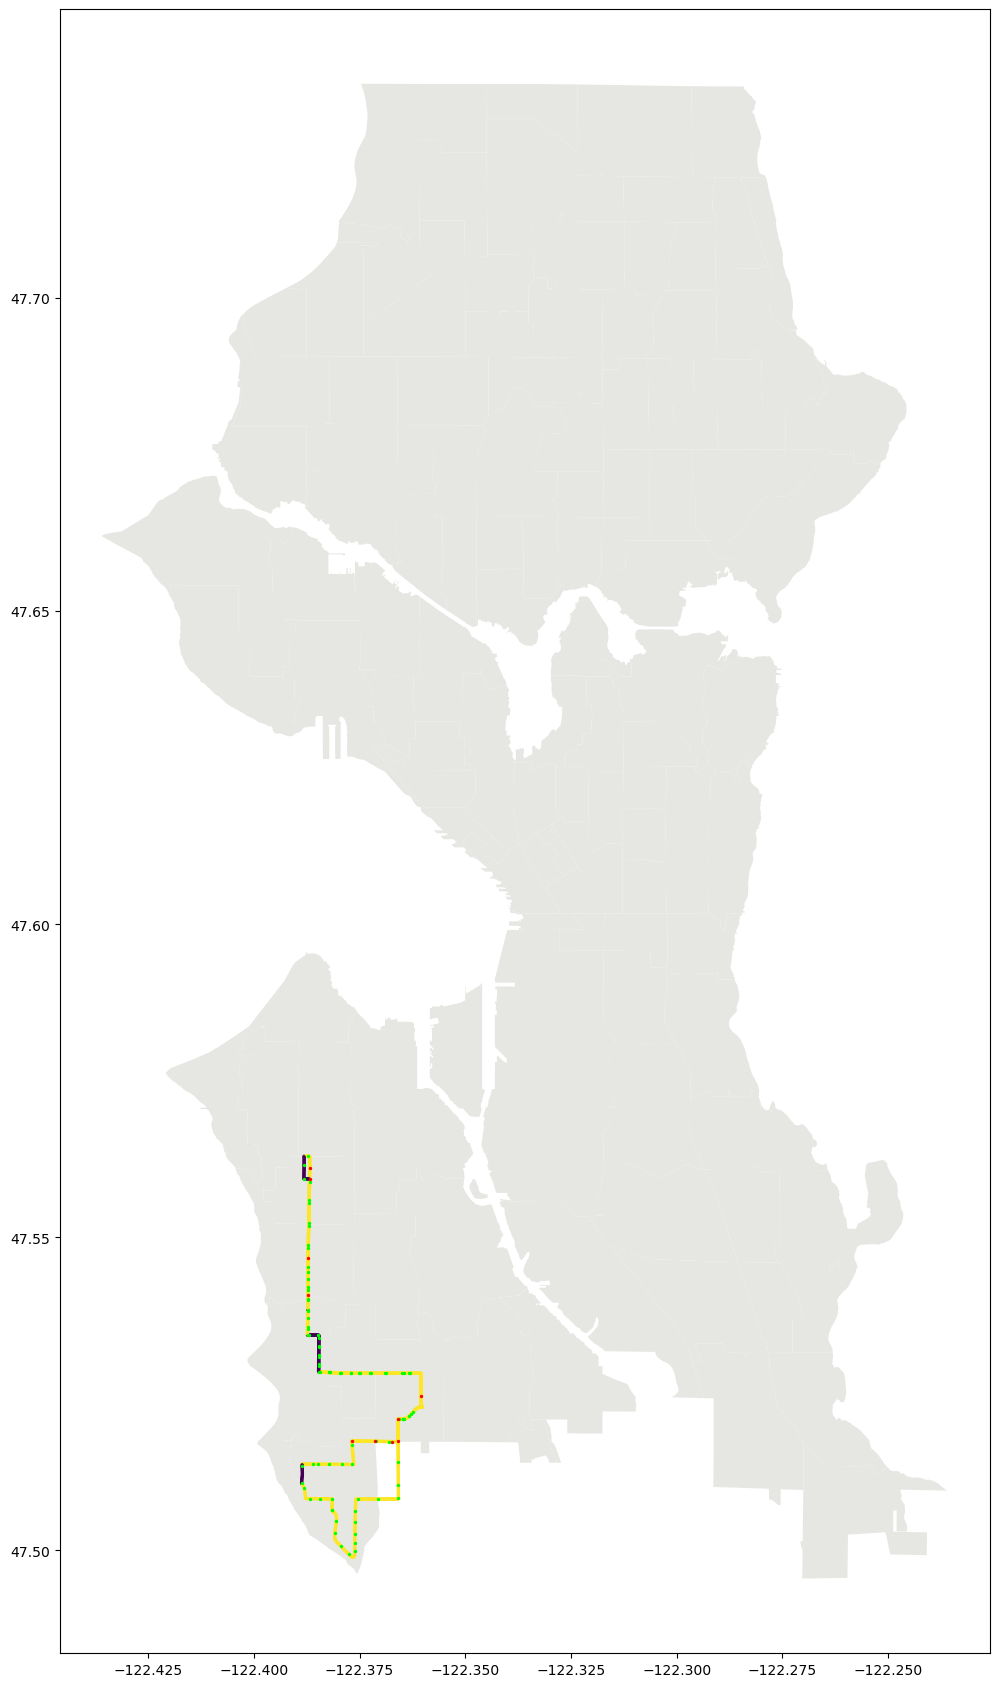

In [14]:
fig, ax = plt.subplots(1, figsize = (12, 30))
#ax.set_xlim(-122.44, -122.23)
#ax.set_ylim(47.49, 47.74)
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
#limits.plot(color="#888888", ax=ax, zorder=5)
gdf = route_sm_map.get_gdf()
segments = route_sm_map.get_segments_by_id()
#gdf.plot(color='green', markersize=2, ax=ax)
gdf.plot(column='speed_limit[km/s]', markersize= 2, ax=ax, alpha = 1, zorder = 10)
gdf[gdf['is_stop'] == True].plot(color='lime', markersize=2, ax=ax, zorder = 15)
gdf[gdf['is_signal'] == True].plot(color='red', markersize=2, ax=ax, zorder = 20)
#streets[streets['SPEEDLIMIT']==25.].plot(column="SPEEDLIMIT", color='red', ax=ax, zorder = 25)
#streets['Index']=streets.index
#streets[streets['Index'].isin(segments)].plot(column="SPEEDLIMIT", color='blue', ax=ax, zorder = 25)

In [119]:
(gdf['speed_limit[km/s]']).unique()

array([0.0089408, 0.011176 ])